## Online learning of dynamical system parameters using a physics-informed neural network

In [1]:
# ---------------------------------------------------------------------------*/
# - import necessary python packages

import numpy as np
from matplotlib import pyplot as plt

import torch

import function as fun

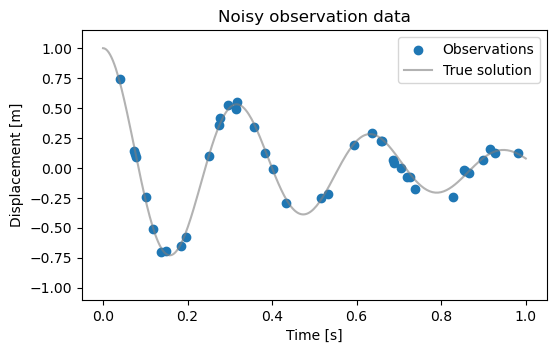

In [2]:
# ---------------------------------------------------------------------------*/
# - configure an under-damped harmonic oscillator

def osc_true(d, w0, t):
    """Compute an analytical solution to an under-damped harmonic oscillator problem."""
    assert d < w0

    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos

    return u

# preset randon number generator to get reproducible results
torch.manual_seed(123)

d, w0 = 2., 20.
mu, k = 2*d, w0**2

# specify frequency setpoint data
w0_epochs = 10000
w0_setpoints = torch.tensor([20, 10, 15, 20], dtype=float).view(-1, 1)
w0_setpoints_n = w0_setpoints.size(dim=0)
w0_data_i = torch.repeat_interleave(w0_setpoints, w0_epochs + 1, dim=0)
w0_data_o = torch.zeros_like(w0_data_i)

# specify number of points
test_n = 300
phys_n = 40
meas_n = 40

t_test = torch.linspace(0., 1., test_n).view(-1, 1) # time points for testing
t_phys = torch.linspace(0., 1., phys_n, requires_grad=True).view(-1, 1) # time points to check physics
t_meas = torch.rand([meas_n, 1])

# response of a true harmonic oscillator
u_meas = osc_true(d, w0, t_meas) + 0.04*torch.randn_like(t_meas)
u_true = osc_true(d, w0, t_test)

# plot observed system
plt.figure(figsize=(6, 3.5))
plt.title("Noisy observation data")
plt.scatter(t_meas[:, 0], u_meas[:, 0], label="Observations")
plt.plot(t_test[:, 0], u_true[:, 0], label="True solution", color="tab:grey", alpha=0.6)
plt.xlabel('Time [s]')
plt.ylabel('Displacement [m]')
plt.ylim([-1.1, 1.15])
plt.legend()
plt.show()

In [3]:
# ---------------------------------------------------------------------------*/
# - neural network for online learning

pinn = fun.neuralnetwork.load('pinn_play_ident_k')
pinn.print()

fcnn(
  (_model): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1, out_features=16, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=16, out_features=1, bias=False)
      (1): Identity()
    )
  )
)


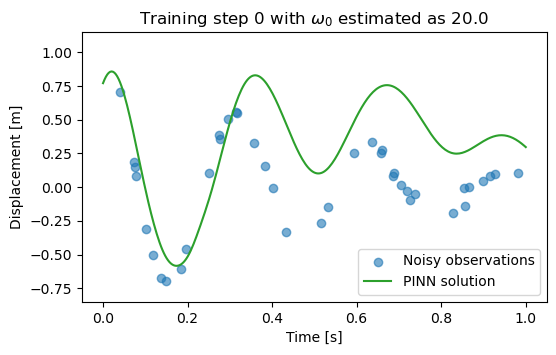

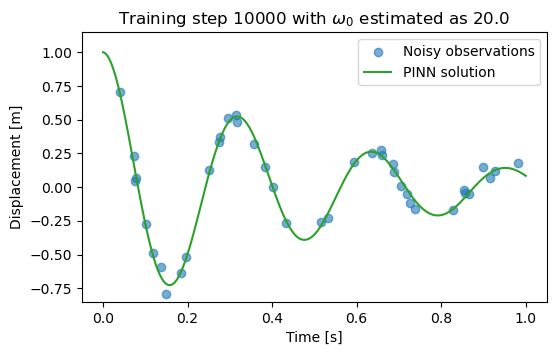

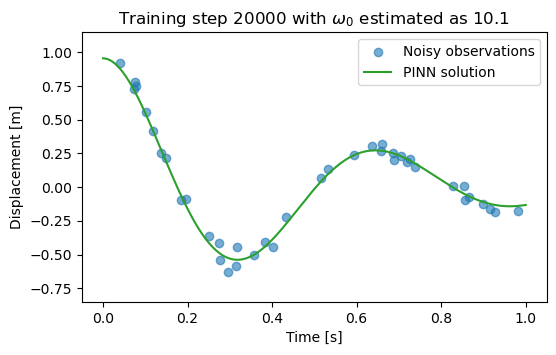

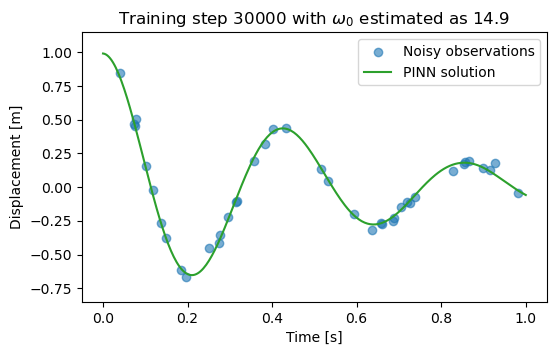

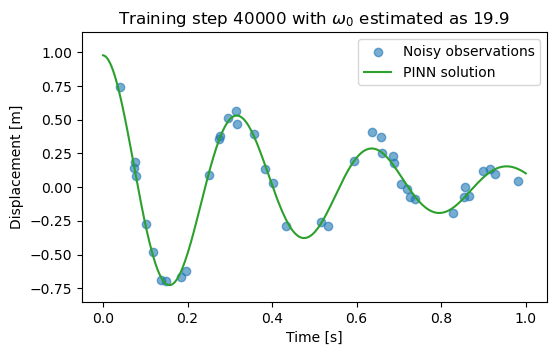

In [4]:
# ---------------------------------------------------------------------------*/
# - online learning

torch.manual_seed(123)

# parameter k is to be identified
k_var = torch.nn.Parameter(k*torch.ones(1, requires_grad=True))
k_var_trace = []

# hyperparameters for loss functions
hyperparam_phys = 8e-1
hyperparam_data = 1e4

# instantiate an optimizer
opt_learningrate = 0.033
opt_params = pinn.parameters + [k_var]
opt = torch.optim.Adam(opt_params, lr=opt_learningrate)

# (re)train this neural network continuously
epochs = w0_setpoints_n * w0_epochs
for epoch in range(epochs + 1):
    # first, measure current true response
    u_meas = osc_true(d, w0_data_i[epoch], t_meas) + 0.04*torch.randn_like(t_meas)

    opt.zero_grad()

    # compute physics loss
    u = pinn(t_phys)
    dudt = torch.autograd.grad(u, t_phys, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_phys, torch.ones_like(dudt), create_graph=True)[0]
    loss_phys = torch.mean((d2udt2 + mu*dudt + k_var*u)**2)

    # compute data loss
    u = pinn(t_meas)
    loss_data = torch.mean((u - u_meas)**2)

    # backpropagate joint loss, take optimiser step
    loss = hyperparam_phys*loss_phys + hyperparam_data*loss_data
    loss.backward()
    opt.step()

    # save k values for later statistics
    this_w0 = np.sqrt(k_var.item())
    w0_data_o[epoch] = this_w0

    # plot results as the training progresses
    if epoch == 0 or epoch != 0 and epoch % w0_epochs == 0:
        with torch.no_grad():
            u = pinn(t_test)
            plt.figure(figsize=(6, 3.5))
            plt.title(f"Training step {epoch} with $\\omega_0$ estimated as {this_w0:.1f}")
            #plt.title(f"Training step {epoch}")
            plt.scatter(t_meas[:, 0], u_meas[:, 0], label="Noisy observations", alpha=0.6)
            plt.plot(t_test[:, 0], u[:, 0], label="PINN solution", color="tab:green")
            plt.xlabel('Time [s]')
            plt.ylabel('Displacement [m]')
            plt.ylim([-0.85, 1.15])
            plt.legend()
            #plt.savefig(f'fig/pinn_play_online_step_{epoch}.svg')
            plt.show()

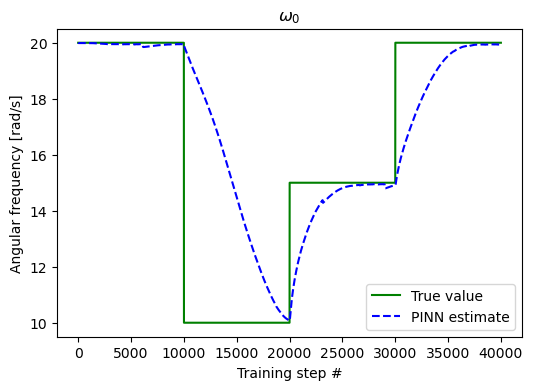

In [5]:
# ---------------------------------------------------------------------------*/
# - check identified parameters

plt.figure(figsize=(6, 4))
plt.title("$\\omega_0$")
plt.plot(w0_data_i[:w0_epochs*w0_setpoints_n], label='True value', color='green')
plt.plot(w0_data_o[:w0_epochs*w0_setpoints_n], label='PINN estimate', color='blue', linestyle='dashed')
plt.legend()
plt.xlabel('Training step #')
plt.ylabel('Angular frequency [rad/s]')
plt.savefig('fig/pinn_play_online_track.svg')
plt.show()